# Data report for the efficacy dataset for shRNA

In [1]:
from oligogym.data import DatasetDownloader
from oligogym.stats import get_cosine_dist_to_nearest_neighbor, get_outliers
from oligogym.features import KMersCounts
from oligogym.models import LinearModel
from oligogym.metrics import regression_metrics

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Processed dataset

In [2]:
downloader = DatasetDownloader()
dataset = downloader.download("sherwood")
dataset.data.head()

,x,y,y_raw,targets,smiles,fasta
0,RNA1{r(A)p.r(A)p.r(A)p.r(A)p.r(A)p.r(A)p.r(A)p...,0.483930,-0.501050,ATP2B3,Cc1cn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3[C@@H](O)...,AAAAAAAACAACTACAACCTTG
1,RNA1{r(A)p.r(A)p.r(A)p.r(A)p.r(A)p.r(A)p.r(A)p...,0.620296,0.152770,TMEM218,Cc1cn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3[C@@H](O)...,AAAAAAATGACAGAGAACCTCG
2,RNA1{r(A)p.r(A)p.r(A)p.r(A)p.r(A)p.r(A)p.r(G)p...,0.588967,0.002563,FGF2,Cc1cn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3[C@@H](O)...,AAAAAAGAAACACTCATCCGTA
3,RNA1{r(A)p.r(A)p.r(A)p.r(A)p.r(A)p.r(A)p.r(G)p...,0.435042,-0.735450,ATG9B,Cc1cn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3[C@@H](O)...,AAAAAAGTCGATAATCTCCAGG
4,RNA1{r(A)p.r(A)p.r(A)p.r(A)p.r(A)p.r(A)p.r(G)p...,0.434042,-0.740240,DUSP21,Cc1cn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3[C@@H](O)...,AAAAAAGTCGTAGAGACGCGAG


## Features statistics

In [3]:
print(dataset.get_helm_stats().to_dict())

{'avg_nt_seq_len': {0: 22.0}, 'combined_unique_monomers': {0: ['A', 'C', 'G', 'T', 'p', 'r']}, 'avg_GC_content': {0: 43.486746900043364}, 'avg_G_content': {0: 20.941229368571417}, 'avg_C_content': {0: 33.01613221575766}, 'avg_A_content': {0: 23.30850582511527}, 'avg_TU_content': {0: 33.204747274841345}, 'num_duplicates': {0: 51706}}


In [4]:
print(f"Total number of datapoint: {dataset.size}")
print(f"Total number of targets: {len(set(dataset.targets))}")
print(f"Total number of unique compounds: {len(set(dataset.x))}")

Total number of datapoint: 291551
Total number of targets: 17802
Total number of unique compounds: 239845


## Labels statistics

In [5]:
print(dataset.get_label_stats().to_dict())

{'nobs': {0: 291551}, 'minmax': {0: (0.0, 1.0)}, 'mean': {0: 0.491721642901708}, 'variance': {0: 0.02312668223137915}, 'skewness': {0: 0.39430074471182974}, 'kurtosis': {0: 0.14830574472332048}, 'num_zeros': {0: 1}}


In [6]:
print(f"{len(get_outliers(dataset.y))} datapoints are identified as outliers by IQR method")

3430 datapoints are identified as outliers by IQR method


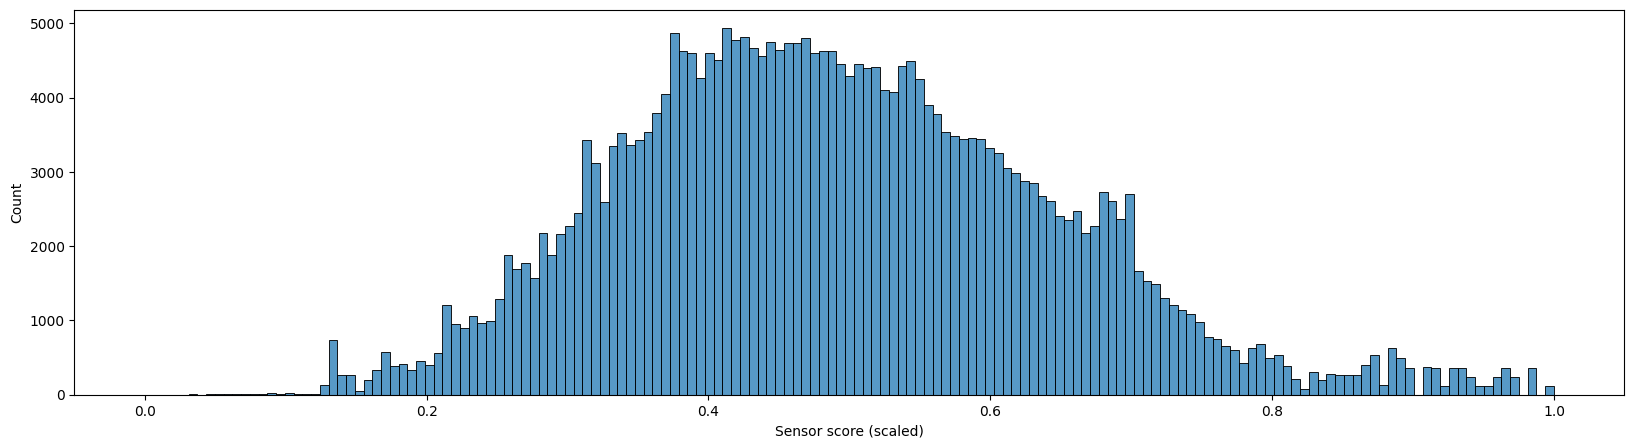

In [7]:
fig,ax=plt.subplots(figsize=[20,5])

sns.histplot(x=dataset.y)
ax.set_xlabel('Sensor score (scaled)')
plt.show()

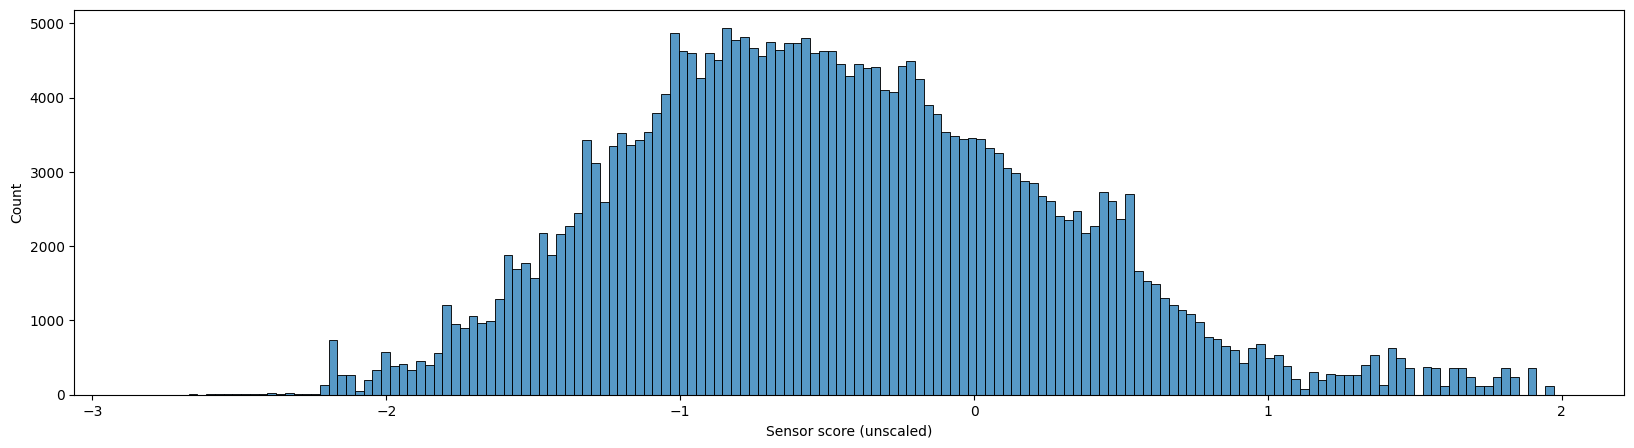

In [8]:
fig,ax=plt.subplots(figsize=[20,5])

sns.histplot(x=dataset.y_raw)
ax.set_xlabel('Sensor score (unscaled)')
plt.show()

## Splitting analysis

Train size: 189880
Train size: 101671


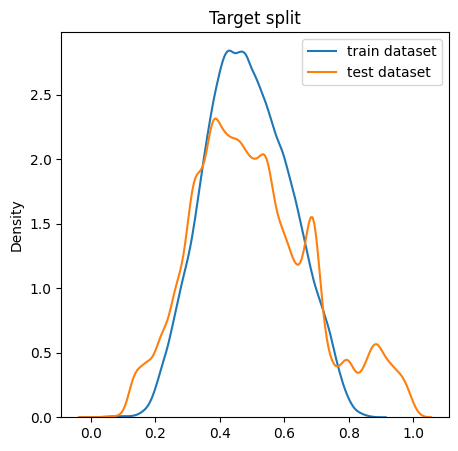

In [9]:
x_train, x_test, y_train, y_test, train_idx, test_idx = dataset.split(split_strategy='target',return_index=True, random_state=42)
print(f'Train size: {len(x_train)}')
print(f'Train size: {len(x_test)}')

fig,ax=plt.subplots(figsize=[5,5])

sns.kdeplot(ax=ax, x=y_train, label='train dataset')
sns.kdeplot(ax=ax, x=y_test, label='test dataset')
ax.set_title('Target split')
ax.legend()
plt.show()

Train size: 233240
Train size: 58311


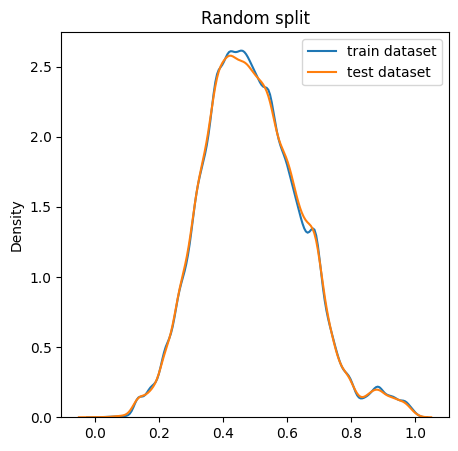

In [10]:
x_train, x_test, y_train, y_test, train_idx, test_idx = dataset.split(split_strategy='random',return_index=True, random_state=42)
print(f'Train size: {len(x_train)}')
print(f'Train size: {len(x_test)}')

fig,ax=plt.subplots(figsize=[5,5])

sns.kdeplot(ax=ax, x=y_train, label='train dataset')
sns.kdeplot(ax=ax, x=y_test, label='test dataset')
ax.set_title('Random split')
ax.legend()
plt.show()

## Predictability analysis

In [11]:
x_train,x_test,y_train,y_test = dataset.split('target',random_state=42)
feat=KMersCounts(k=[1,2,3], modification_abundance=False)
x_train=feat.fit_transform(x_train)
x_test=feat.transform(x_test)
model=LinearModel()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

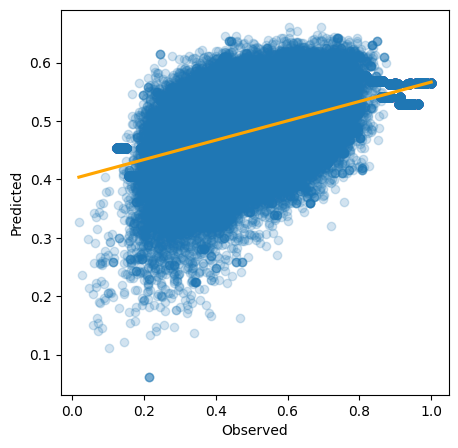

{'r2_score': 0.21645877856820894, 'root_mean_squared_error': 0.1643084411810693, 'mean_absolute_error': 0.13188154940473426, 'pearson_correlation': 0.5086694642110625, 'spearman_correlation': 0.4901083924750439}


In [12]:
fig, ax = plt.subplots(figsize=[5,5])
sns.regplot(ax=ax,x=y_test,y=y_pred,scatter_kws={'alpha':0.2},line_kws={'color':'orange'})
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()
print(regression_metrics(y_test,y_pred))